# How to apply the LLM-as-a-Judge design pattern to develop a financial news retrieval agent?

**Definition**

The **LLM-as-a-Judge** design pattern (also known as **Evaluator-Optimizer**) is an agentic system that uses two agents:

* The first agent generates an initial response based on the user’s query.

* The second agent analyzes the response generated by the first agent and provides critical feedback. It then sends this back to the first agent for revision.

This system runs in a loop until a termination condition is met:

* Either the maximum number of iterations is reached,

* Or satisfactory critical feedback is obtained.

**Use Case:**

The objective of this agentic system is to design an automated agent capable of retrieving up-to-date financial news within a specified geographical region.

For implementation, the OpenAI Agents SDK framework is employed to operationalize the LLM-as-a-Judge design pattern. The retrieval process is constrained by three criteria:

* The news source must be Reuters

* Articles must be recent, i.e., published within the last two days

* The content must be relevant to a predefined region (Europe, Asia, United States)

## Our Agentic System Architecture:

**web_news_searcher:**

The agent is provided with precise instructions to retrieve financial news from Reuters sources, ensuring that only recent dates are considered. In addition, it is equipped with the *WebSearchTool* to enable web access.

**new_evaluator**:

The agent is explicitly instructed to verify three elements: the source link, the publication date, and the user-specified region. Furthermore, the required output format is defined using a Pydantic schema consisting of two fields: (feedback, score).

The score plays a critical role:

* If all required elements are present in the output of the first agent, the score is marked as “successful.”

* Conversely, if any element is missing, the score is set to “unsuccessful,” in which case the agentic system continues its iterative process.


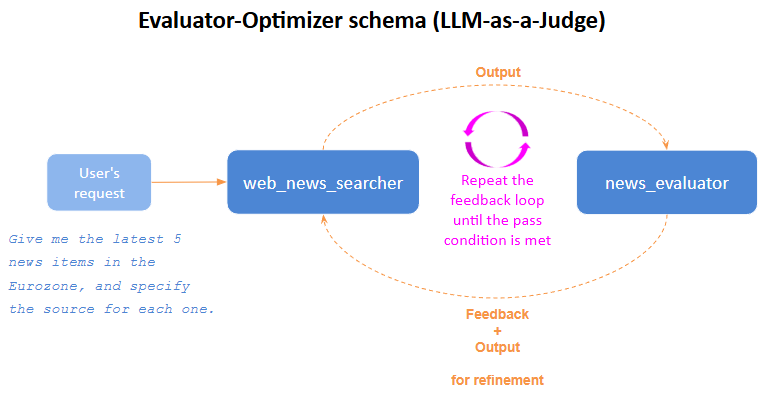

In [32]:
from IPython.display import Image, display
image_path = path+"/web_news_searcher_BOT.png"
display(Image(filename=image_path))

## Install Lib

In order to use OpenAI Agent SDK:

In [1]:
!pip install openai -q

In [2]:
import openai
print(openai.__version__)

1.106.1


In [3]:
!pip install openai-agents -q

You need to create an OpenAI API Key:

In [4]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

import os
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [ ]:
from datetime import datetime, timedelta

In [8]:
import nest_asyncio
nest_asyncio.apply()

from agents import Agent, Runner, WebSearchTool, trace, ItemHelpers, TResponseInputItem
from dataclasses import dataclass
from typing import Literal

In [9]:
import asyncio

# Evaluator-Optimizer Multi-Agent System (LLM-as-a-Judge)

In [24]:
today_date = datetime.now().strftime("%Y-%m-%d")
yesterday_date = (datetime.now() - timedelta(1)).strftime("%Y-%m-%d")
two_days_ago = (datetime.now() - timedelta(2)).strftime("%Y-%m-%d")

INSTRUCTIONS_NEWS_SEARCH = (
    "You are a research news assistant specialized in Finance or any news that can have an impact on the financial health of a given company or a region. "
    "You search the web for a given region to collect the most important and recent news. "
    "Produce a concise summary of the results with citations. The summary must be 2-3 paragraphs and less than 300 words. "
    "Capture the main points. Write succinctly."
    f"Get only the latest news between 2 days ago {two_days_ago} and today {today_date}. "
    "Use only this resource: https://www.reuters.com/. "
    "For each item you are providing, specify the date on which the article was published. "
    "For each item you are providing, specify the complete external link to the article. "
    "This is important. Otherwise, don't give me a summary, if you don't provide a date and an external link. "
    "If you don't give a source link, it means that you are hallucinating. "
)

web_news_searcher = Agent(
        name="web_news_searcher",
        instructions=INSTRUCTIONS_NEWS_SEARCH,
        tools=[WebSearchTool()],
    )

@dataclass
class EvaluationFeedback:
    feedback: str
    score: Literal["successful", "unsuccessful"]

news_evaluator = Agent(
    name="news_evaluator",
    instructions=(
        "You will be given a financial news summary in a given region (Euro, US, Asia) and you are asked to evaluate the completeness of external source links. "
        "Check whether the news summary is supported by external article links from https://www.reuters.com/. "
        f"Check whether the news summary was published between 2 days ago {two_days_ago} and today {today_date}. "
        "For each item of news, the date of the news must be explicitly provided."
        "Check whether the news summary corresponds to the region or regions requested by the user. "
        "If the user requested 'n' news items (it could be 4 or 5 or 10 whatever number the user requests), each item must be supported by an external source link, so you need to ensure that there are 'n' source links. "
        "External links are required for the user to verify the accuracy of the news. "

    ),
    output_type=EvaluationFeedback,
)

In [33]:
news_evaluator

Agent(name='news_evaluator', handoff_description=None, tools=[], mcp_servers=[], mcp_config={}, instructions="You will be given a financial news summary in a given region (Euro, US, Asia) and you are asked to evaluate the completeness of external source links. Check whether the news summary is supported by external article links from https://www.reuters.com/. Check whether the news summary was published between 2 days ago 2025-09-04 and today 2025-09-06. For each item of news, the date of the news must be explicitly provided.Check whether the news summary corresponds to the region or regions requested by the user. If the user requested 'n' news items (it could be 4 or 5 or 10 whatever number the user requests), each item must be supported by an external source link, so you need to ensure that there are 'n' source links. External links are required for the user to verify the accuracy of the news. ", prompt=None, handoffs=[], model=None, model_settings=ModelSettings(temperature=None, top

In [36]:
news_evaluator.model_settings

ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None, parallel_tool_calls=None, truncation=None, max_tokens=None, reasoning=None, verbosity=None, metadata=None, store=None, include_usage=None, response_include=None, top_logprobs=None, extra_query=None, extra_body=None, extra_headers=None, extra_args=None)

# Chat with the Mutli-Agent System

## Give me the latest 5 news in Euro zone, and specify the resource for each one of them.

In [26]:
async def main() -> None:
    msg = input("User's request:")
    input_items: list[TResponseInputItem] = [{"content": msg, "role": "user"}]

    latest_outline: str | None = None

    max_iteration = 4

    nbr_iterations = 0
    while True:
        news_searcher_result = await Runner.run(
            web_news_searcher,
            input_items,
          )

        input_items = news_searcher_result.to_input_list()
        latest_outline = ItemHelpers.text_message_outputs(news_searcher_result.new_items)

        print("\033[92m**************************NEWS SEARCH:**************************\033[0m")
        print(latest_outline)

        print("\n\n\033[92m**************************Running Evaluation:**************************\033[0m")
        news_evaluator_result = await Runner.run(news_evaluator, latest_outline)
        result: EvaluationFeedback = news_evaluator_result.final_output

        print(f"\033[94mEvaluator score: {result.score}\033[0m")
        print("\n")

        print(f"\033[94mEvaluator feedback: {result.feedback}\033[0m")
        print("\n")

        if result.score == "successful":
              print("\033[92m Links check is good ==> stopping the iteration.\033[0m")
              break

        print("\n\n\033[92m**************************Running Refinement:**************************\033[0m")
        print("\033[94mRe-running with feedback for improvements:\033[0m")
        input_items.append({"content": f"News Summary: {latest_outline}", "role": "system"})
        input_items.append({"content": f"Feedback: {result.feedback}\n for each item in the news summary, provide an external source link:", "role": "user"})
        nbr_iterations+=1

        if nbr_iterations>max_iteration:
              print("\033[91mReached max_iteration ==> stopping the iteration.\033[0m")
              break

    print("\n\n\033[92m**************************Final Set of News with Links:**************************\033[0m")
    print(latest_outline)

if __name__ == "__main__":
    asyncio.run(main())

# Input ==> Give me the latest 5 news items in Eurozone, and specify the source for each one.

User's request:Give me the latest 5 news items in Eurozone, and specify the source for each one.
**************************NEWS SEARCH:**************************
Here are the five **most recent** news items related to the Eurozone, as of **September 6, 2025**, along with their sources:

1. **Google hit with a €2.95 billion EU antitrust fine**  
   The European Commission fined Alphabet’s Google a record-breaking **€2.95 billion** (~$3.45 billion) for antitrust violations in ad‑tech.  
   Source: Reuters, published on **September 5, 2025** ([reuters.com](https://www.reuters.com/legal/litigation/google-hit-with-345-billion-eu-antitrust-fine-over-adtech-practices-2025-09-05/?utm_source=openai))

2. **Eurozone’s GDP confirmed at a modest 0.1% growth in Q2**  
   Final figures from Eurostat reaffirmed that the Eurozone economy grew by **0.1% quarter-on-quarter** in the second quarter of 2025.  
   Source: Eurostat announcement (via RTT News) and confirmed by additional outlets ([rttnews.com

### Another Run

In [25]:
if __name__ == "__main__":
    asyncio.run(main())

# Input ==> Give me the latest 5 news items in Eurozone, and specify the source for each one.

User's request:Give me the latest 5 news items in Eurozone, and specify the source for each one.
**************************NEWS SEARCH:**************************
Here are the latest **five** key news items related to the **Eurozone**, as of **September 5–6, 2025**, along with their sources and publication dates:

1. Google hit with €2.95 billion EU antitrust fine over adtech practices  
   — Alphabet’s Google was fined €2.95 billion (~USD 3.45 billion) by the European Commission for anticompetitive behavior in its adtech operations. This decision was announced on **September 5, 2025**, and highlights the EU’s ongoing scrutiny of big tech. ([reuters.com](https://www.reuters.com/legal/litigation/google-hit-with-345-billion-eu-antitrust-fine-over-adtech-practices-2025-09-05/?utm_source=openai))

2. Eurozone GDP and employment up by 0.1% in Q2 2025  
   — Eurostat confirmed that in the **second quarter of 2025**, the euro area’s seasonally adjusted GDP rose by **0.1%**, and employment also

In [ ]:
# # Another kind of outputs that you can have from the bot:
# Below are external **Reuters** links for each of the five Eurozone news items, as requested:

# 1. **Eurozone Q2 GDP growth confirmed at 0.1% (Resilience despite weak environment)**
#    – Report: euro zone economy grew by 0.1% in Q2 2025, aided by Spain, France, and Ireland, offsetting contraction in Germany and Italy.
#    – Source: “Euro zone growth holds up better than feared in Q2” ([reuters.com](https://www.reuters.com/business/euro-zone-growth-holds-up-better-than-feared-q2-2025-07-30/?utm_source=openai))

# 2. **August PMI shows sluggish euro‑zone growth**
#    – Report: Eurozone Composite PMI edged up to 51.0 in August from 50.9, signaling continued modest expansion; services slowed while manufacturing strengthened.
#    – Source: “Euro zone economic growth remains sluggish in August, PMI shows” ([reuters.com](https://www.reuters.com/world/europe/euro-zone-economic-growth-remains-sluggish-august-pmi-shows-2025-09-03/?utm_source=openai))

# 3. **Germany inaugurates the “Jupiter” supercomputer (Europe’s first exascale)**
#    – Report: German Chancellor Friedrich Merz inaugurated the Jupiter supercomputer at Jülich research centre; Europe’s first exascale capable of one billion billion calculations per second.
#    – Source: “Germany's Merz inaugurates Nvidia supercomputer for research” ([reuters.com](https://www.reuters.com/business/media-telecom/germanys-merz-inaugurates-nvidia-supercomputer-research-2025-09-05/?utm_source=openai))

# 4. **France’s political crisis imperils credit rating amid looming confidence vote**
#    – Report: France faces a confidence vote on September 8; political turmoil risks a sovereign credit downgrade from Fitch, which could push France into A+ territory.
#    – Source: “France faces sovereign rating test amid political chaos” ([reuters.com](https://www.reuters.com/business/finance/france-faces-sovereign-rating-test-amid-political-chaos-2025-09-05/?utm_source=openai))
#    – Additionally: “What you need to know about France's political crisis” ([reuters.com](https://www.reuters.com/world/europe/what-you-need-know-about-frances-political-crisis-2025-09-05/?utm_source=openai))

# 5. **European factories return to growth**
#    – Report: Eurozone manufacturing expanded in August for the first time since mid‑2022, with PMI rising to 50.7 due to strong domestic demand.
#    – Source: “European factories return to growth, Asia activity shrinks” ([reuters.com](https://www.reuters.com/world/china/global-economy-european-factories-return-growth-asia-activity-shrinks-2025-09-01/?utm_source=openai))


## Give me the latest news for 2 regions: Eurozone and US

In [27]:
if __name__ == "__main__":
    asyncio.run(main())

# Input ==> Give me the latest 5 news items for each region: Eurozone and US. Specify the source for each one, and organize the news into separate paragraphs by region.

User's request:Give me the latest 5 news items for each region: Eurozone and US. Specify the source for each one, and organize the news into separate paragraphs by region.
**************************NEWS SEARCH:**************************
Here are the **five latest news items** for each region—**Eurozone** and **United States**—organized into separate paragraphs by region. Each item includes its source and precise date where available to avoid ambiguity.

---

Eurozone

1. Eurostat confirmed that the eurozone economy grew by 0.1% in Q2 2025, with the EU overall up by 0.2%. Denmark led regional growth while Germany and Italy lagged behind ([uk.finance.yahoo.com](https://uk.finance.yahoo.com/news/eurozone-gdp-employment-rise-113549218.html?utm_source=openai)).
2. RTT News echoed that the eurozone registered marginal growth of 0.1% in the second quarter, noting that higher consumption partly offset declines elsewhere ([rttnews.com](https://www.rttnews.com/3571989/eurozone-gdp-growth-confirm

### Another Run

In [28]:
if __name__ == "__main__":
    asyncio.run(main())

# Input ==> Give me the latest 5 news items for each region: Eurozone and US. Specify the source for each one, and organize the news into separate paragraphs by region.

User's request:Give me the latest 5 news items for each region: Eurozone and US. Specify the source for each one, and organize the news into separate paragraphs by region.
**************************NEWS SEARCH:**************************
Here are the five **most recent news items** for each region—**Eurozone** and the **United States**—as of **September 6, 2025**. Each item includes its source and is organized by region with distinct paragraphs.

---

Eurozone:

1. Europe’s economy expanded by just **0.1% in Q2 2025**, marking a sluggish performance that lags far behind the U.S. growth rate. German contraction and ongoing trade uncertainties contributed to this subdued outcome. ([courthousenews.com](https://www.courthousenews.com/europes-economy-flatlines-at-0-1-as-us-races-8-times-faster/?utm_source=openai), [uk.finance.yahoo.com](https://uk.finance.yahoo.com/news/eurozone-gdp-employment-rise-113549218.html?utm_source=openai))

2. Final data confirmed the marginal **0.1% GDP growth** i